## NLP by RNN

## Reading the data

In [15]:
nov_path = 'gingatetsudono_yoru.txt'

with open(nov_path, 'r') as f:
    nov_text = f.read()

## Preprocessing

In [16]:
import re

text = re.sub("《[^》]+》", "", nov_text)  # remove <brackets>
text = re.sub("［[^］]+］", "", text) # remove [brackets]
text = re.sub("[｜ 　]", "", text) # remove | and spaces

## Setting up the hyperparameters

In [17]:
n_rnn = 10 # number of characters to consider
batch_size = 128 # number of sequences to consider at once
n_epochs = 60 # number of epochs to train for
n_hidden = 128 # number of hidden units in the RNN

## word2vec

In [18]:
import numpy as np

# create a index to character mapping
chars = list(set(text))
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}

# cut the text in semi-redundant sequences of n_rnn characters
time_chars = []
next_chars = []
for i in range(0, len(text) - n_rnn):
    time_chars.append(text[i: i + n_rnn])
    next_chars.append(text[i + n_rnn])

# create a vectorized representation of the sequences
X = np.zeros((len(time_chars), n_rnn, len(chars)), dtype=np.bool)
y = np.zeros((len(time_chars), len(chars)), dtype=np.bool)
for i, time_char in enumerate(time_chars):
    for t, char in enumerate(time_char):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

<ipython-input-18-d37885ac7414>:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = np.zeros((len(time_chars), n_rnn, len(chars)), dtype=np.bool)
<ipython-input-18-d37885ac7414>:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros((len(time_chars), len(chars)), dtype=np.bool)


## Creating the model
SimpleRNN, LSTM, GRU

In [19]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU

# build the model: a simple RNN
model_rnn = Sequential()
model_rnn.add(SimpleRNN(n_hidden, input_shape=(n_rnn, len(chars))))
model_rnn.add(Dense(len(chars), activation='softmax'))
model_rnn.compile(loss='categorical_crossentropy', optimizer='adam')
model_rnn.summary()

# build the model: a LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(n_hidden, input_shape=(n_rnn, len(chars))))
model_lstm.add(Dense(len(chars), activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam')
model_lstm.summary()

# build the model: a GRU
model_gru = Sequential()
model_gru.add(GRU(n_hidden, input_shape=(n_rnn, len(chars))))
model_gru.add(Dense(len(chars), activation='softmax'))
model_gru.compile(loss='categorical_crossentropy', optimizer='adam')
model_gru.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 128)               150784    
                                                                 
 dense_6 (Dense)             (None, 1049)              135321    
                                                                 
Total params: 286,105
Trainable params: 286,105
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               603136    
                                                                 
 dense_7 (Dense)             (None, 1049)              135321    
                                                                 
Total params: 738,457
Trai

## Defining the setence generator function

In [22]:
from keras.callbacks import LambdaCallback
def on_epoch_end(epochs, logs):
    if(epochs == n_epochs-1 or epochs == 0):
        print('----- Generating text after Epoch: %d' % epochs)
        beta = 5 # temperature
        prev_text = text[0: n_rnn] # seed text
        created_text = prev_text

        print('----- Generating with seed: "' + prev_text + '"')
        for i in range(400):
            # one-hot encode the characters
            X_pred = np.zeros((1, n_rnn, len(chars)))
            for t, char in enumerate(prev_text):
                X_pred[0, t, char_indices[char]] = 1.

            # predict the next character
            preds = model.predict(X_pred, verbose=0)[0]
            p_power = np.asarray(preds).astype('float64')
            p_power = p_power ** beta # modify the distribution
            next_index = np.random.choice(len(p_power), p=p_power/np.sum(p_power))
            next_char = indices_char[next_index]

            created_text += next_char
            prev_text = prev_text[1:] + next_char 
        print(created_text)
        print()

# set up the callbacks
epoch_end_callback = LambdaCallback(on_epoch_end=on_epoch_end)

## Training the model

In [23]:
# train the rnn model
model = model_rnn
history_rnn = model.fit(X, y, batch_size=batch_size, epochs=n_epochs, callbacks=[epoch_end_callback])

Epoch 1/60
300/303 [============================>.] - ETA: 0s - loss: 1.2354----- Generating text after Epoch: 0
----- Generating with seed: "「ではみなさんは、そ"
「ではみなさんは、そうごらんないろ。こともったちですか。」
「何だ、今日は涼しいから。」
「ああ、そうなくらあお父さんの牛乳を見えないたのですからわたっていねえ。」ジョバンニが云いました。
「もう駄目です。落ちてから四十五分たちましたから。」
ジョバンニはまっ赤になって、その人き、ところがつもちらして立っていました。
「ああ、鳥捕りは、黒いのかがらって座っていたのです。
ジョバンニは、あっちの方へ行くの方は見たとしていたした。
「ああ、ジョバンニは眼をあげました。それは二人の人の中に、砂やつかさっているのでした。いるともうなけんとここらだら、」
「あれてもうじっと見え、しいそのをすって来ように、あかりはいったりもの次の水ながら、あっきの方を見てるようしゃした。
「さあ、あったのです。」
「ああ、ジョバンニはお父さんはあることなんだんだんだん。」
「うあ、どうどんですよ。」
「あいつくしいねえ。」ジョバンニは、

303/303 [==============================] - 27s 91ms/step - loss: 1.2350
Epoch 2/60
303/303 [==============================] - 3s 11ms/step - loss: 1.2035
Epoch 3/60
303/303 [==============================] - 3s 9ms/step - loss: 1.1720
Epoch 4/60
303/303 [==============================] - 3s 9ms/step - loss: 1.1455
Epoch 5/60
303/303 [==============================] - 4s 12ms/step - loss: 1.1150
Epoch 6/60
303/303 [================

In [24]:
# train the lstm model
model = model_lstm
history_lstm = model_lstm.fit(X, y, batch_size=batch_size, epochs=n_epochs, callbacks=[epoch_end_callback])

Epoch 1/60
299/303 [============================>.] - ETA: 0s - loss: 5.0015----- Generating text after Epoch: 0
----- Generating with seed: "「ではみなさんは、そ"
「ではみなさんは、そたのいましたののるたうな、たたそいっいたしたたたてのいたのたたいたのくたのてっなた、いましっのなしたてのまた、てのっのいいいううった、うかいたのたいしたたてたましっ
んまった。たたしたたにののまのたのたしたたたののののしたたのいんたしたたたいたのてのた、のしたいいたたのいていたのたののいたた。いたうのたたはの、た。たたのたのたいたまいはたたのたにのいのいたなた、たして、なのたたししたいった。ていんいいなのんてとたてのうたたまいののいいいいなましたのいまていの、のしたのらたまいいたまいのののなのたのたたでうたうた、な。にいいたいのしたのなのののいいいなたたといのななたなたっいいたいなたてでなかてそといたなてのたいたた。の、ないたたたいのいまののたたいいののっなたのまのんたのまたのたたたたの。ののそ、たしい、、たたたたたのたのいのしいのいたのたのたいいいていたのしたのなたののりういをっ、かいま

303/303 [==============================] - 29s 82ms/step - loss: 4.9978
Epoch 2/60
303/303 [==============================] - 2s 6ms/step - loss: 4.6804
Epoch 3/60
303/303 [==============================] - 2s 5ms/step - loss: 4.3750
Epoch 4/60
303/303 [==============================] - 2s 6ms/step - loss: 4.1065
Epoch 5/60
303/303 [==============================] - 2s 5ms/step - loss: 3.9019
Epoch 6/60
303/303 [==================

In [25]:
# train the gru model
model = model_gru
history_gru = model_gru.fit(X, y, batch_size=batch_size, epochs=n_epochs, callbacks=[epoch_end_callback])

Epoch 1/60
294/303 [============================>.] - ETA: 0s - loss: 5.0374----- Generating text after Epoch: 0
----- Generating with seed: "「ではみなさんは、そ"
「ではみなさんは、そたまたい、たったののたたたいたののたのいいたたのたのたたまのたのたたののたった。ったっとたのしたたたったたいた。たたたのしたったたのかた。とてたた。こたまたました。ののたったした。したいったいたい。た。のでいた。いたった。たのっした。したたいたた。いたたのしたたっにたっったとた。たとまたっ、。たたまいいたい。た。たったったいっいたたでたいたたしたたいかまたたたたった。でたしたした。ったったっしたったてままたたったまったしたったました。いないたたたいたまた。た。したしたのなたたたいったたたたったたした。たしたったたでたはたたってた。したまも。ないたった。っしたいったたったのたじたかに、のいたったたたのたたとったしたたたののいたがったっいたたたのの。たいたったったた。たたなたのまた。らいた。たたたった。たたかた、のた。くた。たののたっったたのた。たたたた。いた。た。いたた。たのはた。た、はいた

303/303 [==============================] - 29s 87ms/step - loss: 5.0310
Epoch 2/60
303/303 [==============================] - 2s 5ms/step - loss: 4.4775
Epoch 3/60
303/303 [==============================] - 2s 5ms/step - loss: 3.8972
Epoch 4/60
303/303 [==============================] - 2s 6ms/step - loss: 3.5740
Epoch 5/60
303/303 [==============================] - 2s 6ms/step - loss: 3.3475
Epoch 6/60
303/303 [==================

## History

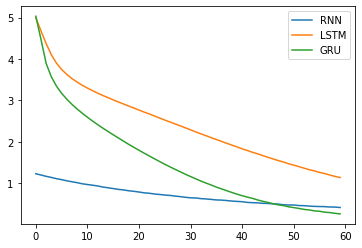

In [26]:
loss_rnn = history_rnn.history['loss']
loss_lstm = history_lstm.history['loss']
loss_gru = history_gru.history['loss']

import matplotlib.pyplot as plt
plt.plot(loss_rnn, label='RNN')
plt.plot(loss_lstm, label='LSTM')
plt.plot(loss_gru, label='GRU')
plt.legend()
plt.show()